# Time Series Analysis in the Real World:  Climate Change

You are a data scientist interested in climate change.  You obtain a dataset containing the average monthly temperatures over 10 years (1981-1990) in the city Melbourne, Australia.  You would like to build a predictive model to forecast Melbourne's temperature based on the observed data.  This data is stored as a CSV file on the Math@Work server.

In [1]:
import pandas as pd
temperatures = pd.read_csv('https://www.mathatwork.org/DATA/melbourne-temps-monthly.csv')

**1]** Examine the characteristics of your dataset.

In [2]:
print(temperatures.head())
print(temperatures.tail())
print(temperatures.dtypes)

      Month  Temperature
0  1/1/1981         17.7
1  2/1/1981         17.7
2  3/1/1981         13.5
3  4/1/1981         12.4
4  5/1/1981          9.5
         Month  Temperature
115   8/1/1990          7.8
116   9/1/1990          9.2
117  10/1/1990         11.3
118  11/1/1990         12.7
119  12/1/1990         14.4
Month           object
Temperature    float64
dtype: object


**2]** Examine the summary statistics of your dataset.

In [3]:
print(temperatures.describe())

       Temperature
count   120.000000
mean     11.200833
std       3.143928
min       4.600000
25%       8.475000
50%      11.100000
75%      13.800000
max      17.700000


**3]** Are there any outliers in your dataset?  Is the data approximately normal or is it skewed?  Explain and support your explanation with analyses.

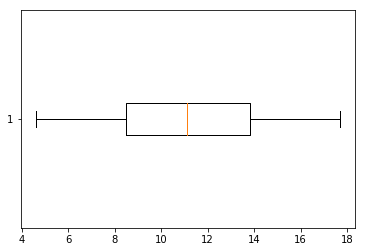

In [4]:
import matplotlib.pylab as plt
plt.boxplot(temperatures.Temperature, vert=False)
plt.show()

Working on the assumption that the data has been preprocessed to include no missing values or bad data entries, conclude that the data is of good quality for analyses.

**4]** Plot a line chart of the data.  Explain in the cell below your graph whether there is clear evidence of trend and/or seasonality.

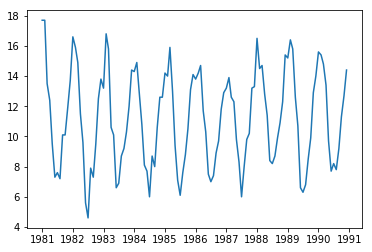

In [6]:
from datetime import datetime
temperatures.Month = pd.to_datetime(temperatures.Month)

plt.plot(temperatures.Month, temperatures.Temperature)
plt.show()

**5]** Chart the rolling statistics plots.  In the cell below your graph, explain by looking at the rolling statistics whether there is clear evidence of trend and/or seasonality.

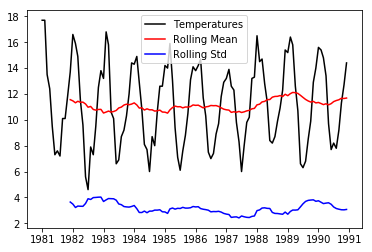

In [7]:
rollmean=temperatures.Temperature.rolling(window=12).mean()
rollstd=temperatures.Temperature.rolling(window=12).std()

plt.plot(temperatures.Month, temperatures.Temperature, color='black', label='Temperatures')
plt.plot(temperatures.Month, rollmean, color='red', label='Rolling Mean')
plt.plot(temperatures.Month, rollstd, color='blue', label='Rolling Std')
plt.legend()
plt.show()

**6]** Use **seasonal_decompose( )** to decompose your time series data.  Plot the decomposition and explain in the cell below your graph whether there is clear evidence of trend and/or seasonality.

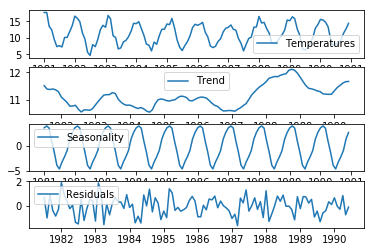

In [8]:
temperatures.index = temperatures.Month
temperatures = temperatures.drop('Month', axis=1)

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(temperatures)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.title('Seasonal Decomposition')

plt.subplot(411)
plt.plot(temperatures, label='Temperatures')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.show()

**7]** Use a Dickey-Fuller test to determine whether your *temperatures* dataset is stationary.  Explain below your analysis using 85% confidence.

In [9]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(temperatures.Temperature)
pvalue = pd.Series(dftest[1], index=['p-value'])

print(pvalue)

p-value    0.335137
dtype: float64


**8]** Apply first order differencing to the *temperatures* data.  

In [11]:
temperatures_lag1 = temperatures.shift(periods=1)
temperatures_first_diff = temperatures - temperatures_lag1
temperatures_first_diff.dropna(inplace=True)

print(temperatures_first_diff.head())

            Temperature
Month                  
1981-02-01          0.0
1981-03-01         -4.2
1981-04-01         -1.1
1981-05-01         -2.9
1981-06-01         -2.2


**9]** Apply a Dickey-Fuller test to recheck stationarity.  Explain in the cell below your analysis your interpretation of the p-value at a 95% confidence level. 

In [12]:
dftest2 = adfuller(temperatures_first_diff.Temperature)
pvalue2 = pd.Series(dftest2[1], index=['p-value'])

print(pvalue2)

p-value    0.000118
dtype: float64


**10]** Assuming that *temperatures_first_diff* was confirmed stationary, use Python's **auto.arima( )** to find the best ARIMA model to make predictions regarding Melbourne's average monthly temperatures.  Pass in *seasonal=True* if there was evidence of seasonality present.

In [13]:
from pyramid.arima import auto_arima

best_arima_model = auto_arima(temperatures, m=12, seasonal=True, d=1, D=1, trace=False, error_action='ignore', suppress_warnings=True)

**11]** Split the data into testing and training subsets.  Use 1/1/89 to 12/1/90 as your test data and train on the rest.

In [14]:
test = temperatures.loc['1/1/89':'12/1/90']
train = temperatures.loc['1/1/80':'12/1/88']

**12]** Use the training data to train your model.

In [15]:
best_arima_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

**13]** Use the testing data to evaluate your model.  In the cell below your analysis, explain how well your model predicts.

In [16]:
from sklearn.metrics import r2_score

arima_predict = best_arima_model.predict(n_periods=len(test))
eval_metric = r2_score(y_pred=arima_predict, y_true=test)
print(eval_metric)

0.7594012417138891


**14]** Convert your predictions to a Pandas DataFrame.  Then use Pandas **.sort_index( )** to reorder the DataFrame by Month.  Print your predictions to the screen.

In [17]:
arima_predict = pd.DataFrame(arima_predict, index=test.index, columns=['Predictions'])
arima_predict.sort_index(inplace=True)

print(arima_predict)

            Predictions
Month                  
1989-01-01    15.794094
1989-02-01    15.521922
1989-03-01    15.253355
1989-04-01    13.290403
1989-05-01    11.349895
1989-06-01     8.964362
1989-07-01     8.108013
1989-08-01     9.347918
1989-09-01    10.591030
1989-10-01    11.653908
1989-11-01    13.798420
1989-12-01    15.401951
1990-01-01    16.523408
1990-02-01    16.263974
1990-03-01    16.008144
1990-04-01    14.057928
1990-05-01    12.130156
1990-06-01     9.757361
1990-07-01     8.913748
1990-08-01    10.166390
1990-09-01    11.422239
1990-10-01    12.497854
1990-11-01    14.655102
1990-12-01    16.271370


**15]** Plot the predictions vs the actual temperatures data values to help you see how good your predictions are.  Remember to use Pandas **.sort( )** to reorder the test DataFrame by Month before plotting.

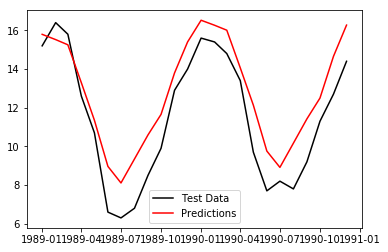

In [18]:
test.sort_index(inplace=True)

plt.plot(test.index, test.Temperature, color='black', label='Test Data')
plt.plot(arima_predict.index, arima_predict.Predictions, color='red', label='Predictions')
plt.legend(loc='best')
plt.show()

**16]** Does the plot verify what R Squared indicated regarding how well future data is likely to be predicted by the model? Explain.

**17]** Assuming your R Squared is satisfactory and therefore indicates good model performance, use the ARIMA model to make predictions about future Melbourne average monthly temperatures.  Refit the model to the entire *temperatures* time series dataset.  Print the refitted model summary.

In [19]:
model_fitted = best_arima_model.fit(temperatures)
print(model_fitted.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -160.491
Date:                            Mon, 11 Feb 2019   AIC                            328.982
Time:                                    10:31:47   BIC                            339.674
Sample:                                         0   HQIC                           333.316
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0079      0.009      0.877      0.381      -0.010       0.025
ma.L1         -0.8081      0.069   

**18]** Make predictions 24 months into the future.

In [21]:
projections = model_fitted.predict(n_periods=len(test))

**19]** Run the following code to create the data months for which you are projecting and then convert your projections into a DataFrame with indices equal to the future date months.

In [22]:
from dateutil.relativedelta import *

new_date = temperatures.index[-1]
new_index = []

for y in range(len(test)):
    new_date = new_date + relativedelta(months=+1)
    new_index.append(new_date)
    
projections = pd.DataFrame(projections, index=new_index, columns=['Projections'])
print(projections)

            Projections
1991-01-01    15.603922
1991-02-01    15.870042
1991-03-01    15.262078
1991-04-01    12.995379
1991-05-01    10.695085
1991-06-01     8.125161
1991-07-01     7.649364
1991-08-01     8.636352
1991-09-01     9.875987
1991-10-01    11.276384
1991-11-01    13.477347
1991-12-01    14.915539
1992-01-01    16.071503
1992-02-01    16.345479
1992-03-01    15.745372
1992-04-01    13.486528
1992-05-01    11.194091
1992-06-01     8.632022
1992-07-01     8.164081
1992-08-01     9.158926
1992-09-01    10.406416
1992-10-01    11.814670
1992-11-01    14.023489
1992-12-01    15.469537


**20]** Plot your *temperatures* and *projections* data.

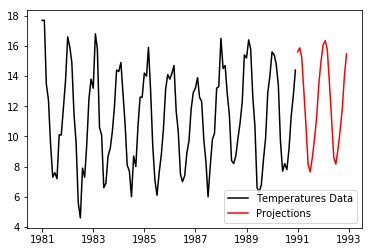

In [23]:
plt.plot(temperatures.index, temperatures.Temperature, color='black', label='Temperatures Data')
plt.plot(projections.index, projections.Projections, color='red', label='Projections')
plt.legend(loc='best')
plt.show()

**21]** Do your projections indicate a trend in Melbourne's average montly temperatures? Explain.